# **Esercizi Scikit Learn**
## *Esercitazione su Scikit Learn*

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.datasets import load_diabetes, load_iris
from sklearn.feature_selection import (
    SelectKBest,
    mutual_info_regression,
    mutual_info_classif)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression)
from sklearn.metrics import (
    adjusted_rand_score,
    mean_absolute_percentage_error,
    precision_score,
    recall_score)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor)

%matplotlib inline

## **Es 9.0**

Caricare i dataset Diabetes (a scopo di *regressione*) ed Iris (a scopo di *classificazione*). Visualizzarne rapidamente la struttura.

- Studiare le feature e la distribuzione delle stesse del dataset Diabetes.
- Effettuare un'analisi delle **cross-correlazioni** presenti tra le feature del dataset Diabetes. Utilizzare il $\tau$ di Kendall.
- Isolare le $k$ feature più importanti del dataset Diabetes. Per farlo, utilizzare un oggetto di classe `SelectKBest()` scegliendo la metrica più appropriata tra `mutual_info_regression` e `mutual_info_classif`.
- Comparare i risultati di regressione ottenuti da un regressore lineare e da un albero decisionale in termini di *MAPE*.
- Provare ad eseguire una `GridSearchCV` sull'albero decisionale, e valutare se i risultati in termini di MAPE migliorano.

Ripetere gli stessi step degli esercizi precedenti per il dataset Iris.

- Comparare, per mezzo di due pipeline, i risultati ottenuti effettuando il **clustering** mediante algoritmo **KMeans** sui dati di Iris con e senza *feature selection*.

Partiamo dalla regressione usando il dataset [*diabetes*](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset), contenente 442 campioni ed 11 attributi, di cui i primi 10 sono variabili *indipendenti* (le $x_i$), mentre l'ultimo è una misura quantitativa della progressione della malattia dopo un anno.

In particolare:

| Attributo | Descrizione |
| --------- | ----------- |
| age | Età (in anni) |
| sex | Genere |
| bmi | Indice di massa corporea |
| bp | Pressione media |
| s1 tc | Colesterolo totale |
| s2 ldl | Lipoproteine a bassa densità |
| s3 hdl | Lipoproteine ad alta densità |
| s4 tch | Colesterolo totale / HDL |
| s5 ltg | Livello di trigliceridi |
| s6 glu | Livello di zucchero nel sangue |

Carichiamo il dataset e vediamone la testa.

In [3]:
data = load_diabetes(as_frame=True)
#data.data.head()
data.data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


Vediamo adesso le label:

In [8]:
data.target

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Name: target, Length: 442, dtype: float64

Vediamo adesso la distribuzione delle differenti feature:

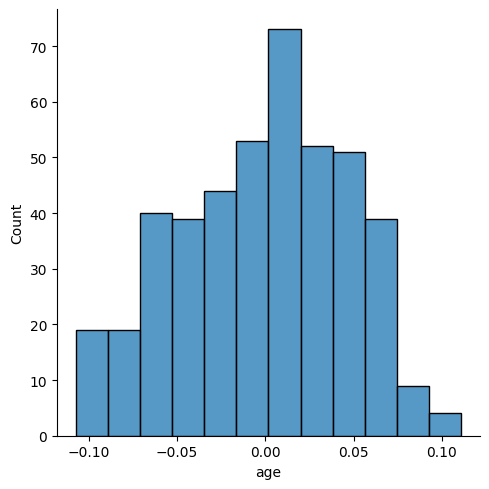

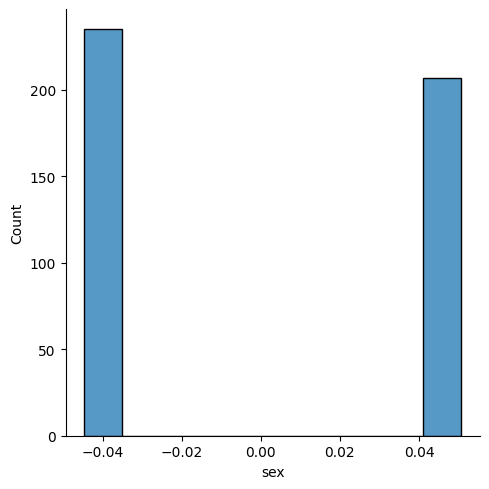

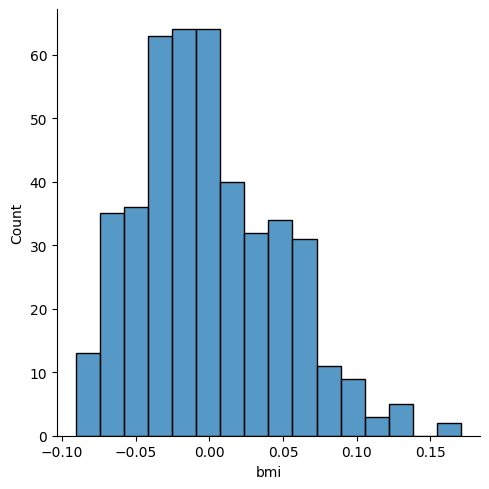

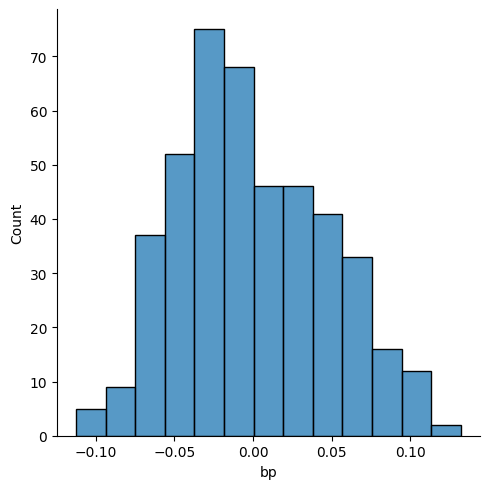

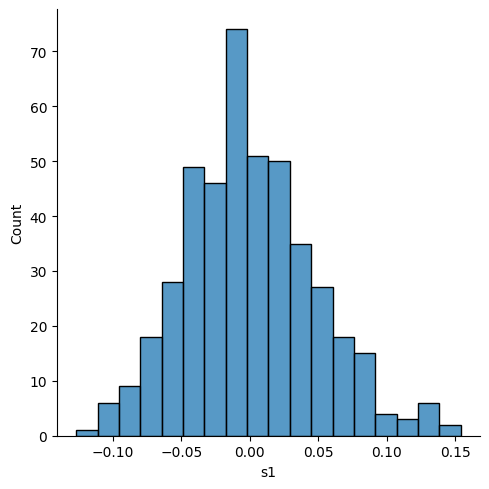

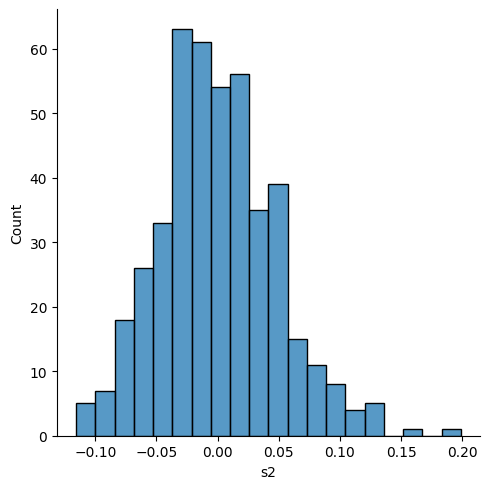

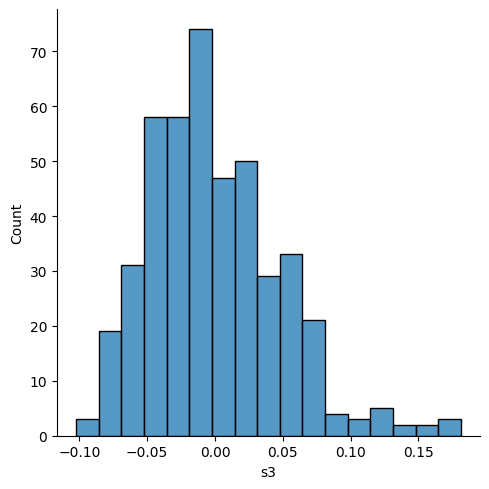

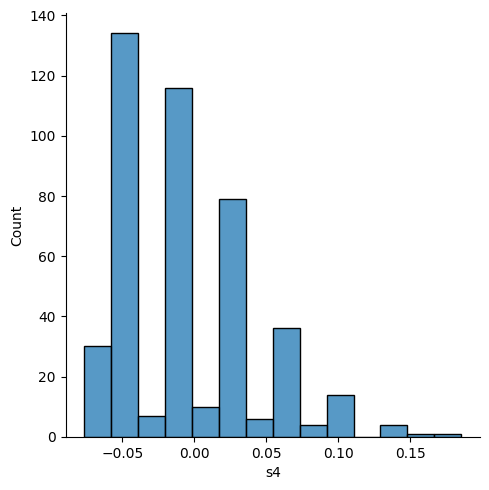

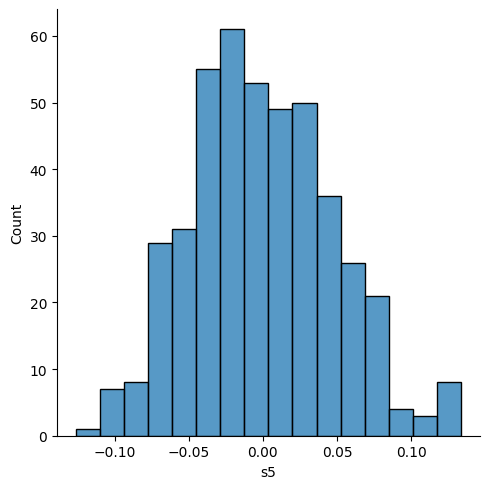

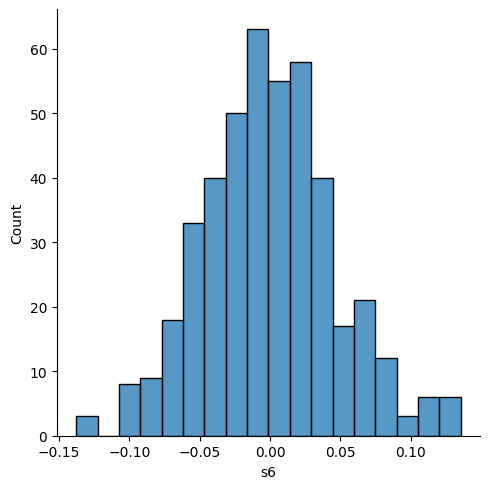

In [5]:
for col in data.data.columns:
    sns.displot(data=data.data, x=col)

La distribuzione della maggior parte delle feature è di tipo normale. La presenza di valori negativi ci suggerisce inoltre che le feature siano già state normalizzate.
Valutiamo adesso la collinearità tra le variabili.

<AxesSubplot:>

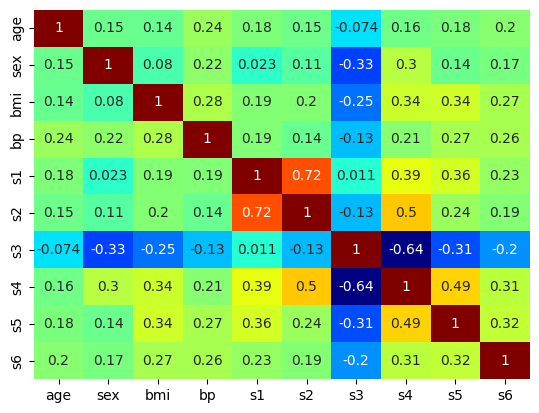

In [6]:
sns.heatmap(
    data.data.corr(method='kendall'),
    annot=True,
    cmap='jet',
    cbar=False)


Vi è una moderata anticorrelazione tra s2/s3 ed s4, il che è prevedibile dalla descrizione delle feature. Ad ogni modo, non vi è una chiara collinearità.

Proviamo ad effettuare una procedura di feature selection mediante `SelectKBest()`.

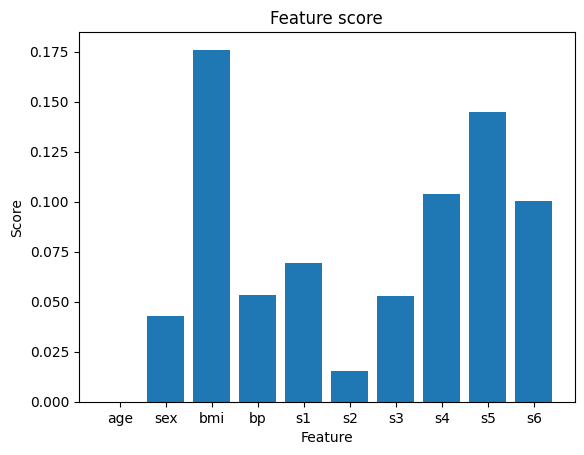

In [9]:
def plot_feat_score(X, y, cols, metric):
    selector = SelectKBest(metric, k=X.shape[-1])
    selector.fit(X, y)
    _, ax = plt.subplots()
    ax.bar(cols, selector.scores_)
    ax.set_title("Feature score")
    ax.set_xlabel("Feature")
    ax.set_ylabel("Score")
    plt.show()

plot_feat_score(
    data.data.values,
    data.target,
    data.data.columns,
    mutual_info_regression)

Notiamo che, tra le diverse feature, quelle relative ad età, genere ed *s2* hanno un punteggio abbastanza basso, per cui un'idea sarebbe quella di scegliere le restanti sette.

In [10]:
selector = SelectKBest(mutual_info_regression, k=7)
X_tr = selector.fit_transform(data.data.values, data.target)

Compariamo il MAPE ottenuto da una regressione lineare e da un albero decisionale.

In [11]:
lr = LinearRegression()
lr.fit(X_tr, data.target)
y_pred = lr.predict(X_tr)
mape_lr = mean_absolute_percentage_error(data.target, y_pred)
print(f'MAPE: {mape_lr}')

MAPE: 0.3995316396745657


In [12]:
dt = DecisionTreeRegressor()
dt.fit(X_tr, data.target)
y_pred = dt.predict(X_tr)
mape_dt = mean_absolute_percentage_error(data.target, y_pred)
print(f'MAPE: {mape_dt}')

MAPE: 0.0


Proviamo ad effettuare una grid search, e vediamo se il MAPE migliora.

In [13]:
params = {
    'criterion': ['squared_error', 'absolute_error', 'poisson']
}

gs = GridSearchCV(dt, params, scoring='neg_mean_absolute_percentage_error')
gs.fit(X_tr, data.target)
bdt = gs.best_estimator_
bdt.fit(X_tr, data.target)
y_pred = bdt.predict(X_tr)
mape_bdt = mean_absolute_percentage_error(data.target, y_pred)
print(f'MAPE: {mape_bdt}')
print(f'Migliori parametri: {gs.best_params_}')

MAPE: 0.0
Migliori parametri: {'criterion': 'poisson'}




Proviamo adesso a valutare un dataset per la classificazione, ovvero il solito [*iris*](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset). Questo contiene 150 campioni con 4 attributi, 50 per ciascuna delle tre classi presenti, ovvero Setosa, Versicolour e Virginica.

Gli attributi sono:

| Attributo | Descrizione |
| --------- | ----------- |
| sepal length | Lunghezza del sepalo in cm. |
| sepal width | Larghezza del sepalo in cm. |
| petal length | Lunghezza del petalo in cm. |
| petal width | Larghezza del petalo in cm. |

Iniziamo mostrando al solito i dati e le label.

In [14]:
iris = load_iris(as_frame=True)
iris.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [15]:
iris.target

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int32

Valutiamo anche in questo caso la distribuzione dei valori assunti dalle feature.

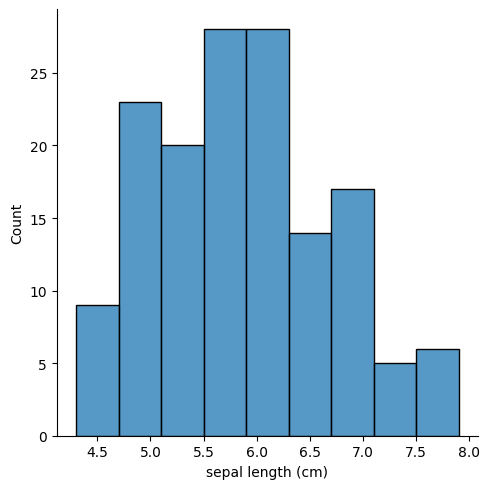

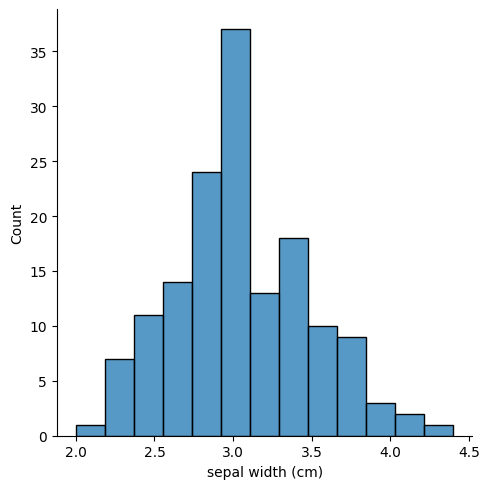

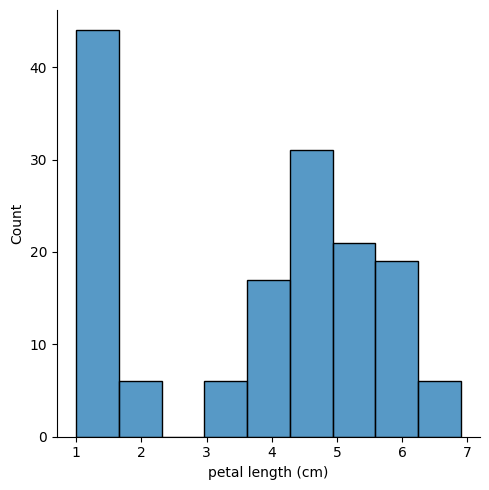

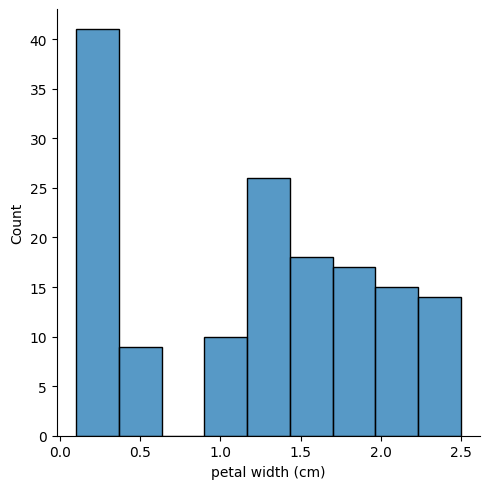

In [17]:
for col in iris.data.columns:
    sns.displot(data=iris.data, x=col)

Notiamo che le feature relative ai petali non sono distribuite secondo una normale. Ciò implica che, se l'algoritmo lo richiede, dovremo effettuare una standardizzazione dei dati.

Valutiamo adesso la collinearità delle feature.

<AxesSubplot:>

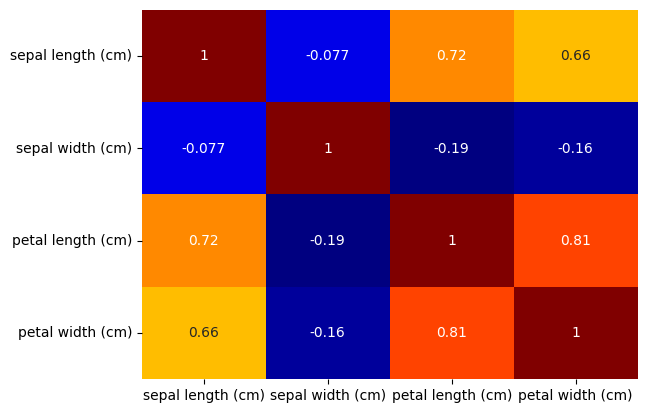

In [18]:
sns.heatmap(
    iris.data.corr(method='kendall'),
    annot=True,
    cmap='jet',
    cbar=False)

In questo caso esiste una certa collinearità tra le diverse feature, il che ci suggerisce che sia possibile effettuare una procedura di feature selection.

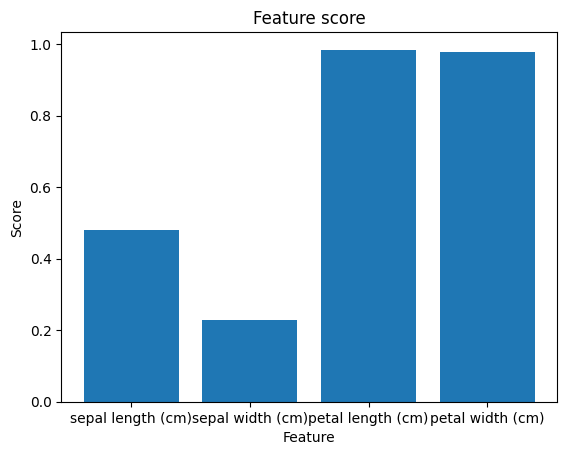

In [19]:
plot_feat_score(
    iris.data.values,
    iris.target,
    iris.data.columns,
    mutual_info_classif)

Dall'analisi della feature importance, emerge che le feature massimamente importanti sono quelle relative alla lunghezza ed alla larghezza dei petali. Proviamo quindi a valutare precisione e recall in diverse situazioni.

In [22]:
log = LogisticRegression()
log.fit(iris.data.values, iris.target)
y_pred = log.predict(iris.data.values)
pr_log = precision_score(
    iris.target,
    y_pred,
    average='weighted')
rc_log = recall_score(
    iris.target,
    y_pred,
    average='weighted')
print(f'Precisione: {pr_log} - Recall: {rc_log}')

Precisione: 0.9738247863247864 - Recall: 0.9733333333333334


c:\Users\Marco Cecca\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
selector = SelectKBest(mutual_info_classif, k=2)
X_tr = selector.fit_transform(
    iris.data.values,
    iris.target)

log = LogisticRegression()
log.fit(X_tr, iris.target)
y_pred = log.predict(X_tr)
pr_log = precision_score(
    iris.target,
    y_pred,
    average='weighted')
rc_log = recall_score(
    iris.target,
    y_pred,
    average='weighted')
print(f'Precisione: {pr_log} - Recall: {rc_log}')

Precisione: 0.9667867146858743 - Recall: 0.9666666666666667


In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_tr, iris.target)
y_pred = dt.predict(X_tr)
pr_dt = precision_score(
    iris.target,
    y_pred,
    average='weighted')
rc_dt = recall_score(
    iris.target,
    y_pred,
    average='weighted')
print(f'Precisione: {pr_dt} - Recall: {rc_dt}')

Precisione: 0.9934640522875816 - Recall: 0.9933333333333333


In ultimo, vediamo come cambiano le prestazioni di un algoritmo di clustering usando come metrica l'ARI agendo sui dati a valle della feature selection.

In [27]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(mutual_info_classif, k=2)),
    ('estimator', KMeans())
])
pipe.fit(iris.data.values, iris.target)
y_pred = pipe['estimator'].labels_
adjusted_rand_score(iris.target, y_pred)

0.5755495329950645

In [28]:
pipe.fit(X_tr, iris.target)
y_pred = pipe['estimator'].labels_
adjusted_rand_score(iris.target, y_pred)

0.5790222058076728